## Regresión usando Random Forest en Python

In [59]:
# En python, típicamente importamos todas las librerías qeu se vayan a usar en la primera parte del código
# Para esto necesitamos las siguientes librerías
import pandas as pd # manipulación de datos
import matplotlib.pyplot as plt # graficación
import datetime as dt # manejo de fechas
import numpy as np # para manejar arreglos de datos 

# librerías de modelado
from sklearn.model_selection import train_test_split # para hacer división entre train-test

### Obtención de los datos

In [60]:
# Obtenemos datos de clima (temperatura) en Seattle, WA, USA
# En 2016
features = pd.read_csv('temps.csv')
features = features[[x for x in features.columns if 'forecast' not in x]]

# 5 primeras filas
features.head(5)

,year,month,day,week,temp_2,temp_1,average,actual,friend
0,2016,1,1,Fri,45,45,45.6,45,29
1,2016,1,2,Sat,44,45,45.7,44,61
2,2016,1,3,Sun,45,44,45.8,41,56
3,2016,1,4,Mon,44,41,45.9,40,53
4,2016,1,5,Tues,41,40,46.0,44,41


Vemos que la data corresponde con una serie temporal

Columnas:

- year: Año
- mes: Mes del año
- dia: Día del mes
- week: Día de la semana
- temp_2: temperatura máxima 2 dias anteriores
- temp_1: temperatura máxima 1 día anterior 
- average: tempratura promedio máxima históricamente
- actual: tempratura máxima
- friend: predicción estimada de alguien, un número aleatorio 20 grados por encima del promedio o 20 grados por debajo

### Limpieza/manipulación de datos

In [61]:
# construimos una columna de fecha para más fácil graficación de la serie de tiempo
features['date'] = features['year'].astype(str) + '-' + features['month'].astype(str) + '-' + features['day'].astype(str)

# extraigo los valores de la fecha separando los elementos de x por '-' y luego los convierto a entero (porque dt.date requiere enteros)
features['date'] = features['date'].apply(
        lambda x: dt.date(
            int(x.split('-')[0]), 
            int(x.split('-')[1]), 
            int(x.split('-')[2]))
        )

# a ver la fecha
features['date'].head(5)

0    2016-01-01
1    2016-01-02
2    2016-01-03
3    2016-01-04
4    2016-01-05
Name: date, dtype: object

In [62]:
# primero revisamos las estadísticas básicas del dataset para determinar si hay alguna anomalía en los datos
features.describe()

,year,month,day,temp_2,temp_1,average,actual,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.580460,62.629310,59.760632,62.543103,60.034483
std,0.0,3.498380,8.772982,11.914773,11.869266,10.527306,11.794146,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,71.000000
max,2016.0,12.000000,31.000000,92.000000,92.000000,77.400000,92.000000,95.000000


Parece no haber ninguna anomalía en los datos

### Análisis exploratorio

Text(0.5, 1.0, '2 días antes de la temperatura máxima')

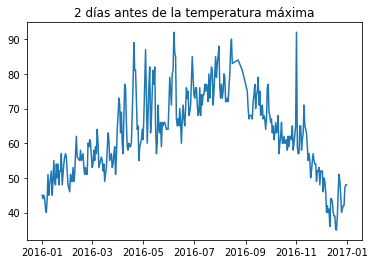

In [63]:
# graficamos algunas columnas de la serie de tiempo para ver si hay algún error en los datos
plt.plot(features.date, features.temp_2)
plt.title("2 días antes de la temperatura máxima")

Text(0.5, 1.0, '1 día antes de la temperatura máxima')

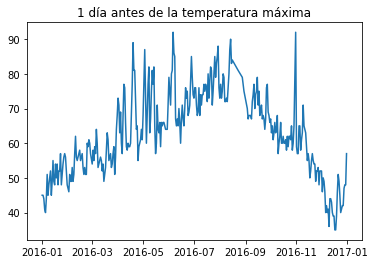

In [64]:
plt.plot(features.date, features.temp_1)
plt.title("1 día antes de la temperatura máxima")

Text(0.5, 1.0, 'Estimado aleatorio de una persona')

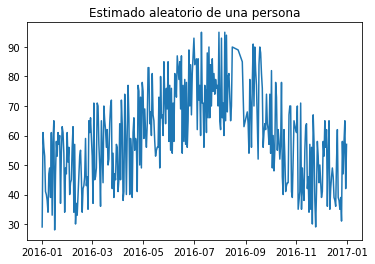

In [65]:
plt.plot(features.date, features.friend)
plt.title("Estimado aleatorio de una persona")

Text(0.5, 1.0, 'Temperatura máxima promedio')

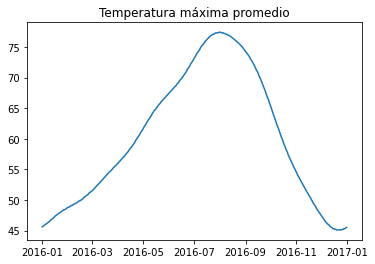

In [66]:
plt.plot(features.date, features.average)
plt.title("Temperatura máxima promedio")

Text(0.5, 1.0, 'Temperatura máxima real (variable de respuesta)')

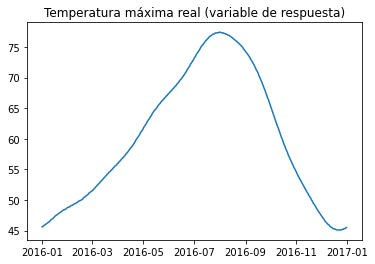

In [67]:
plt.plot(features.date, features.average)
plt.title("Temperatura máxima real (variable de respuesta)")

### Tratamiento/selección de variables

Los modelos de este tipo generalmente requieren que los datos que se le introduzcan para entrenamiento y predicción vengan en un array de numpy (es un arreglo de datos como una matriz).

La idea es que los datos mantienen su forma, pero cambia su tipo de dato, ya que los arrays de numpy son **MUCHO** más rápidos de procesar.

##### One hot encoding

Previo a introducir los datos en el modelo, tenemos una variable categórica, que es el día de la semana:

In [68]:
features.week.head(5)

0     Fri
1     Sat
2     Sun
3     Mon
4    Tues
Name: week, dtype: object

Esta variable es de tipo `object`, lo que quiere decir que es texto (u otro objeto). Sin embargo, los modelos requieren datos únicamente numéricos. Para lidiar con esto, aplicamos una técnica que se llama One-hot encoding, que convierte variables categóricas de múltiples niveles en varias variables numéricas.

En este caso, la variable tiene 7 niveles, uno por cada día de la semana, por lo que esto nos resultará en 7 variables numéricas 

In [69]:
# aplicamos la funcion get dummies de pandas
features = pd.get_dummies(features[[x for x in features.columns if x!='date']])

features[[x for x in features.columns if 'week' in x]]

,week_Fri,week_Mon,week_Sat,week_Sun,week_Thurs,week_Tues,week_Wed
0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0
3,0,1,0,0,0,0,0
4,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...
343,0,0,0,0,0,1,0
344,0,0,0,0,0,0,1
345,0,0,0,0,1,0,0
346,1,0,0,0,0,0,0


Podemos ver que el resultado son 7 variables, excluyendo `week`, ya que la eliminamos a favor de estas 7 variables que representan la misma información, pero de manera numérica.

Donde había un 'Mon' (lunes), ponemos un 1, si la fila representaba otro día de la semana diferente a lunes, entonces la variable correspondiente con el día de la semana lunes tendrá un 0. Y así con los demás días.

##### Separar variables para modelado en 'predictores' y 'respuesta'

Agregamos `.values` al final para convertir los datos a un array de numpy

In [70]:
# Predictores
pred = features[[x for x in features.columns if x != 'actual']].values

# Respuesta
resp = features['actual'].values

Guardamos los nombres de las variables para utilizarlas luego

In [71]:
# Guardar nombres de los predictores en una variable
feature_names = [x for x in features.columns if x != 'actual']

# Guardar nombre de la respuesta en una variable
resp_name = 'actual'

### Modelado

#### Train-test split

### Evaluación del modelo